In [ ]:
import datetime
import logging
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score
import joblib
import tensorflow as tf
from tensorflow import keras
from keras.layers import Reshape, MaxPool3D, Bidirectional, ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Conv2D
from keras.layers import Dropout
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso
import pymongo
import random
import string
import fasttext
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tag import pos_tag
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

HOME = os.environ['LIMA_HOME']


In [ ]:
def clean(text: str) -> list:
    """
    clean text with tokenization; stemming; removing stop word, punctuation, number, and empty string.

    Args:
        text (str): text

    Returns:
        list: cleaned text as list of tokenized str
    """

    # to list of token
    text = word_tokenize(text)

    # stemming and convert to lower case if not proper noun: punctuation and stop word seem to help POS tagging, remove them after stemming
    word_tag = pos_tag(text)
    porter = PorterStemmer()
    text = [
        porter.stem(each[0])
        if each[1] != "NNP" and each[1] != "NNPS" else each[0]
        for each in word_tag
    ]

    # remove stop word: it seems stemming skip stop word; OK to remove stop word after stemming;
    stop_word = set(stopwords.words('english'))
    text = [each for each in text if not each in stop_word]

    # remove punctuation
    text = [
        each.translate(str.maketrans('', '', string.punctuation))
        for each in text
    ]
    # text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text) # if using re

    # convert number to <NUM>
    text = ["<NUM>" if each.isdigit() else each for each in text]

    # remove empty string
    text = [each for each in text if each != ""]

    return text

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = data.copy()
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
        
		names += [f'{data.columns[j]}(t-{i})' for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [f'{data.columns[j]}(t)' for j in range(n_vars)]
		else:
			names += [f'{data.columns[j]}(t+{i})' for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def get_TS_cv(k=10, test_size=None):
    """
    ML models do not need to care about forecast horizon when splitting training and test set. Forecast horizon should be handled by feature preparation ([X_t-1,X_t-2...]). Actually repeated K-fold can also be used, but stick to TS split to align with TS_evaluate().
    """
    return TimeSeriesSplit(
        n_splits=k,
        gap=0,
        test_size=test_size,
    )

def evaluate_series(y_true, y_pred, horizon):
    """
    Some models (like ARIMA) may not support cross_validate(), compare the forecasting result directly
    Args:
        y_true: y of test set
        y_pred: y of prediction
        horizon: forecast horizon

    Returns:
        DataFrame: single row DF with 3 metrics wrt horizon
    """
    # RMSE
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2=r2_score(y_true, y_pred)
    forecast_error = {
        'h': horizon,
        'mae': [mae],
        'rmse': [rmse],
        'mape': [mape],
        'r2':[r2],
        'descriptions': ""
    }
    return forecast_error


In [ ]:
# set random seed
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
h = 1
past = 10

## Metrics features

In [ ]:
from influxdb_client import InfluxDBClient
client= InfluxDBClient.from_config_file(f"{HOME}/dev/DB/influxdb_config.ini")
query_api = client.query_api()
df_WTI = query_api.query_data_frame("""
from(bucket: "dummy")
  |> range(start: 2011-04-01, stop: 2019-04-01)
  |> filter(fn: (r) => r["_measurement"] == "WTI") 
  |> filter(fn: (r) => r["type"] == "closing_price") 
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> drop(columns: ["_start", "_stop"])
""")
df_WTI=df_WTI[["_time","CLC4","CLC3","CLC2","CLC1"]]
df_WTI.columns=["Date","CLC4","CLC3","CLC2","CLC1"]
df_WTI.set_index("Date",inplace=True)
df_WTI.index=df_WTI.index.map(lambda each: each.date())
df_WTI.index=pd.to_datetime(df_WTI.index)
client.close()

In [ ]:
month=[each.month for each in df_WTI.index]
day=[each.day for each in df_WTI.index]
day_in_week=[each.weekday() for each in df_WTI.index]

In [ ]:
df_dt=pd.DataFrame()
df_dt["month"]=month
df_dt["day"]=day
df_dt["day_in_week"]=day_in_week
df_dt.index=df_WTI.index

In [ ]:
df_WTI

## Text features

In [ ]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_db = mongo_client["lima"]
mongo_collection = mongo_db["investing_news"]
cursor = mongo_collection.find({"News":{"$ne":"NEURONswap: First Dex To Implement Governance 2.0"}})
df_news =  pd.DataFrame(list(cursor))[["Date","News"]]
df_news=df_news[df_news.Date.isin(df_WTI.index)]
fasttext_model = fasttext.load_model(f"{HOME}/data/big/cc.en.300.bin")
df_news.News = df_news.News.apply(lambda r: " ".join(clean(r)))

### sentiment features

In [ ]:
def get_sentiment_aggregated(df):
    df=df.copy()
    df["Polarity"] = df.apply(
        lambda row: TextBlob(row['News']).sentiment.polarity, axis=1)
    df["Subjectivity"] = df.apply(
        lambda row: TextBlob(row['News']).sentiment.subjectivity, axis=1)
    df_daily_averaged_sentiment_score = df.groupby(['Date']).mean()
    return df_daily_averaged_sentiment_score

df_sentiment = get_sentiment_aggregated(df_news)
df_sentiment["Combined_Sentiment"]=df_sentiment.Polarity*(1+df_sentiment.Subjectivity)
def decay_features(df):
    window_size=5
    feature_list=[]
    for each in df.columns:
        feature_list.append(df[each].iloc[:window_size].to_list())
    feature_num=len(feature_list)
    for idx in range(window_size,len(df_sentiment)):
        feature_tmp=np.zeros(feature_num)
        for t in range(window_size):
            for feature_idx in range(feature_num):
                feature_tmp[feature_idx]+=df.iloc[idx-t][df.columns[feature_idx]]*((window_size-t)/window_size)
        for feature_idx in range(feature_num):
            feature_list[feature_idx].append(feature_tmp[feature_idx])
    df_result=pd.DataFrame(feature_list).transpose()
    df_result.index=df.index
    df_result.columns=[f"Decay_{each}" for each in df.columns]
    return df_result

df_res=decay_features(df_sentiment)
df_sentiment=pd.concat([df_sentiment,df_res],axis=1)

### topic modeling features

In [ ]:
def get_topic_aggregated(df):
    df=df.copy()
    news_emb = df.News.apply(lambda x: fasttext_model.get_sentence_vector(
        (x))).to_numpy().tolist()
    news_emb = np.array(news_emb)
    emb_scaler=MinMaxScaler()
    news_emb=emb_scaler.fit_transform(news_emb)
    lda_model=LatentDirichletAllocation(n_components=5,n_jobs=-1)
    topic= lda_model.fit_transform(news_emb)
    for i in range(5):
        df[f"Topic{i+1}"] = topic[:, i]
    df_daily_averaged_topic = df.groupby(['Date']).mean()
    return df_daily_averaged_topic, emb_scaler, lda_model

df_topic, emb_scaler, lda_model = get_topic_aggregated(df_news)
df_topic.head()

In [ ]:
df_res=decay_features(df_topic)
df_topic=pd.concat([df_topic,df_res],axis=1)

In [ ]:
df_topic.head(1)

In [ ]:
df_Xy = pd.concat([df_sentiment,df_topic, df_WTI], axis=1, join="inner")
df_Xy.shape

### Embedding

In [ ]:
def aggregate_emb_maxmin(emb):
    data=np.array(emb.to_numpy().tolist())
    return np.concatenate([data.max(axis=0),data.min(axis=0)])
def aggregate_emb_maxmeanmin(emb):
    data=np.array(emb.to_numpy().tolist())
    return np.concatenate([data.max(axis=0),data.mean(axis=0),data.min(axis=0)])

news_emb = df_news.News.apply(lambda x: fasttext_model.get_sentence_vector(
        (x)))
# news_emb = np.array(news_emb)
# emb_scaler=MinMaxScaler()
# news_emb=emb_scaler.fit_transform(news_emb)

In [ ]:
df_emb=pd.concat([df_news.Date,news_emb],axis=1)
df_emb

In [ ]:
# daily mean of mean
# df_emb["News"]=df_emb.News.apply(lambda r:np.array(r.tolist()).mean())

# daily mean
# df_emb=df_emb.groupby("Date").mean()

# max + min
# df_emb=df_emb.groupby("Date")['News'].agg(aggregate_emb_maxmin)

# max + mean + min
df_emb=df_emb.groupby("Date")['News'].agg(aggregate_emb_maxmeanmin)

df_emb=pd.DataFrame(df_emb)
# df_emb.set_index("Date",inplace=True)
df_emb.index=pd.to_datetime(df_emb.index)
df_emb

In [ ]:
# filter to align
df_emb=df_emb[df_emb.index.isin(df_WTI["CLC1"].index)]
# emb=df_emb.to_numpy()
# emb =np.array([each.tolist() for each in emb])
# emb.shape

In [ ]:
# y=df_WTI[df_WTI.index.isin(df_emb.index)]["CLC1"].to_numpy()
# y.shape
# feature_name="EMB_maxmeanmin_single"

### Event

In [ ]:
# os.environ["CORENLP_HOME"]="~/.stanfordnlp_resources/stanford-corenlp-4.1.0/"
# from openie import StanfordOpenIE
# openie_client= StanfordOpenIE()

In [ ]:
# event_tuples = []
# for idx, row in df_news.iterrows():
#     text = row['News']
#     for triple in openie_client.annotate(text):
#         triple['Date'] = row['Date']
#         event_tuples.append(triple)
# openie_client.client.stop()

In [1520]:
# df_events = pd.DataFrame(event_tuples)
df_events=pd.read_pickle("df_events.pkl")
df_events.subject = df_events.subject.apply(
    lambda x: fasttext_model.get_sentence_vector((x)))
df_events.relation = df_events.relation.apply(
    lambda x: fasttext_model.get_sentence_vector((x)))
df_events.object = df_events.object.apply(lambda x: fasttext_model.get_sentence_vector(
    (x)))
df_events.dropna(inplace=True)
df_events.head(2)

,subject,relation,object,Date
0,"[-0.015874106, -0.014480274, -0.08655736, 0.05...","[-0.08357154, -0.017450938, -0.036429703, 0.12...","[-0.031064937, 0.048873972, -0.019095859, 0.06...",2019-03-29
1,"[-0.021661486, -0.026249636, -0.034816958, -0....","[-0.0053701503, -0.06189313, -0.089259215, -0....","[0.032303195, -0.020144327, -0.024541315, 0.03...",2019-03-29


In [1521]:
def aggregate_emb_maxmeanmin(emb):
    data=np.array(emb.to_numpy().tolist())
    return np.concatenate([data.max(axis=0),data.mean(axis=0),data.min(axis=0)])

# max + mean + min
series_subject=df_events.groupby("Date")['subject'].agg(aggregate_emb_maxmeanmin)
series_relation=df_events.groupby("Date")['relation'].agg(aggregate_emb_maxmeanmin)
series_object=df_events.groupby("Date")['object'].agg(aggregate_emb_maxmeanmin)

In [1522]:
df_event_emb=pd.concat([series_subject,series_relation,series_object],axis=1)
df_event_emb.index=pd.to_datetime(df_event_emb.index)
df_event_emb.shape

(1963, 3)

In [1523]:
# filter to align
# df_event_emb=df_event_emb[df_event_emb.index.isin(df_WTI["CLC1"].index)]
# join 3 : (-1,2700)
# df_event_emb["event"]=df_event_emb.apply(np.concatenate,axis=1)
# join 3 : (-1,3,900)
df_event_emb["event"]=df_event_emb.apply(np.array,axis=1)
# event_emb=df_event_emb["event"].to_numpy()
# event_emb=np.array([each.tolist() for each in event_emb])
# X=event_emb
# event_emb.shape

In [ ]:
df_event_emb.shape

## Analysis

In [ ]:
df_Xy.head()

In [ ]:
# stationary test before diff
from statsmodels.tsa.stattools import adfuller
for i in range(df_Xy.shape[1]):
    test_result=adfuller(df_Xy[df_Xy.columns[i]].to_numpy())
    if test_result[1]>0.05:
        print(f"{df_Xy.columns[i]}: {test_result[1]}")

In [ ]:
df_Xy.columns[:]
# df_Xy.columns[7:]#
df_Xy.columns[:-4]

In [ ]:
from statsmodels.tsa.api import VAR
endo=df_Xy[df_Xy.columns[-4:]].to_numpy()
exo=df_Xy[df_Xy.columns[:-4]].to_numpy()
model = VAR(endog=exo,exog=endo)
var_result=model.select_order(30)
var_result.selected_orders

In [565]:
for each in df_Xy.columns[:-1]:
    try:
        endo=df_Xy[["CLC1",each]].to_numpy()
        model = VAR(endo)
        var_result=model.select_order(120)
        print(f"{each}: {var_result.selected_orders}")
    except:
        print(f"ERROR: {each}")

Polarity: {'aic': 15, 'bic': 5, 'hqic': 5, 'fpe': 15}
Subjectivity: {'aic': 15, 'bic': 5, 'hqic': 6, 'fpe': 15}
Combined_Sentiment: {'aic': 15, 'bic': 5, 'hqic': 5, 'fpe': 15}
Decay_Polarity: {'aic': 19, 'bic': 1, 'hqic': 2, 'fpe': 19}
Decay_Subjectivity: {'aic': 14, 'bic': 1, 'hqic': 2, 'fpe': 14}
Decay_Combined_Sentiment: {'aic': 19, 'bic': 1, 'hqic': 2, 'fpe': 19}
Topic1: {'aic': 15, 'bic': 5, 'hqic': 6, 'fpe': 15}
Topic2: {'aic': 15, 'bic': 5, 'hqic': 10, 'fpe': 15}
Topic3: {'aic': 10, 'bic': 5, 'hqic': 10, 'fpe': 10}
Topic4: {'aic': 29, 'bic': 5, 'hqic': 10, 'fpe': 22}
Topic5: {'aic': 10, 'bic': 6, 'hqic': 10, 'fpe': 10}
Decay_Topic1: {'aic': 18, 'bic': 1, 'hqic': 4, 'fpe': 18}
Decay_Topic2: {'aic': 13, 'bic': 1, 'hqic': 6, 'fpe': 13}
Decay_Topic3: {'aic': 14, 'bic': 1, 'hqic': 9, 'fpe': 14}
Decay_Topic4: {'aic': 24, 'bic': 1, 'hqic': 9, 'fpe': 24}
Decay_Topic5: {'aic': 9, 'bic': 1, 'hqic': 9, 'fpe': 9}
CLC4: {'aic': 6, 'bic': 2, 'hqic': 2, 'fpe': 6}
CLC3: {'aic': 6, 'bic': 2, 'hq

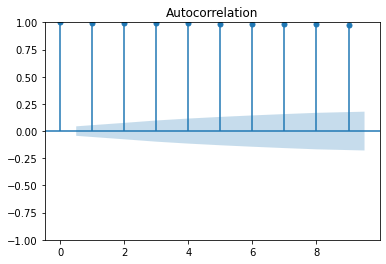

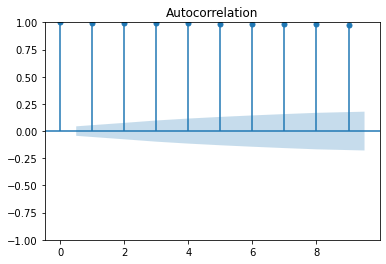

In [566]:
import statsmodels.tsa
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_Xy.CLC3,lags=9, alpha=0.05)

In [573]:
from statsmodels.tsa.stattools import grangercausalitytests
all_results=[]
for each in df_Xy.columns:
    if each =="CLC1":
        continue
    rest_results=grangercausalitytests(df_Xy[["CLC1",each]],maxlag=20,verbose=False)
    for lag in range(1,20):
        all_results.append({"type":each,"lag":lag, "p":rest_results[lag][0]['ssr_ftest'][1]})
df_test=pd.DataFrame(all_results)


In [576]:
df_test.sort_values("p")[20:40]

,type,lag,p
156,Topic3,5,0.098527
353,CLC2,12,0.101438
42,Combined_Sentiment,5,0.102356
139,Topic2,7,0.103006
5,Polarity,6,0.104308
313,CLC4,10,0.104320
332,CLC3,10,0.113395
175,Topic4,5,0.117546
211,Decay_Topic1,3,0.118395
350,CLC2,9,0.121168


In [ ]:
feature_name="day"
df_selected=df_Xy#[[feature_name,'CLC1']]

In [ ]:
# feature selection with Granger
# df_g_test=df.sort_values("p")
# selected_features_series=[]
# for idx,each in df_g_test.iterrows():
#     series=df_Xy[each["type"]].shift(each["lag"])
#     series.name=f"{each['type']}(t-{each['lag']})"
#     selected_features_series.append(series)
# df_selected=pd.concat(selected_features_series,axis=1).dropna()
# df_selected.columns[:]

In [ ]:
df_selected[df_selected.columns[:1]].shape

## Features processing

In [1304]:
# preserve original price for inverting prediction
df_original_price = df_Xy[["CLC1"]].shift(h).dropna()
# 1st order DIFF
df_selected = df_Xy.diff().dropna()
df_nodiff = df_Xy.dropna()
# shift back $past days
past=20
df_selected = series_to_supervised(df_selected, past, h)
df_nodiff = series_to_supervised(df_nodiff, past, h)
# df_selected = series_to_supervised(df_emb, past, h)

df_original_price = df_original_price[df_original_price.index.isin(df_selected.index)]
# remove current day features for forecast
for each in df_selected.columns[:-1]:
    if "(t)" in each:
        df_selected.drop(each, axis=1, inplace=True)
        df_nodiff.drop(each, axis=1, inplace=True)
        

# add time feature without shift 
df_selected=pd.concat([df_dt,df_selected],axis=1).dropna()
df_nodiff=pd.concat([df_dt,df_nodiff],axis=1).dropna()
df_nodiff=df_nodiff[df_nodiff.index.isin(df_selected.index)]

In [1305]:
# # EMB
# df_emb = series_to_supervised(df_emb, past, h)
# for each in df_emb.columns:
#     if "(t)" in each:
#         df_emb.drop(each, axis=1, inplace=True)
# df_emb = df_emb[df_emb.index.isin(df_selected.index)]
# df_emb.columns

In [1524]:
# event-EMB
df_event_emb = series_to_supervised(df_event_emb[["event"]], past, h)
for each in df_event_emb.columns:
    if "(t)" in each:
        df_event_emb.drop(each, axis=1, inplace=True)
df_event_emb = df_event_emb[df_event_emb.index.isin(df_selected.index)]
df_event_emb.columns

Index(['event(t-20)', 'event(t-19)', 'event(t-18)', 'event(t-17)',
       'event(t-16)', 'event(t-15)', 'event(t-14)', 'event(t-13)',
       'event(t-12)', 'event(t-11)', 'event(t-10)', 'event(t-9)', 'event(t-8)',
       'event(t-7)', 'event(t-6)', 'event(t-5)', 'event(t-4)', 'event(t-3)',
       'event(t-2)', 'event(t-1)'],
      dtype='object')

In [1526]:
df_selected=df_selected[df_selected.index.isin(df_event_emb.index)]
df_nodiff=df_nodiff[df_nodiff.index.isin(df_event_emb.index)]
df_original_price=df_original_price[df_original_price.index.isin(df_event_emb.index)]
print(f"{df_selected.shape} | {df_original_price.shape}")
print(f"{df_selected.shape} | {df_nodiff.shape}")
print(f"{df_selected.shape} | {df_event_emb.shape}")
(df_event_emb.index==df_selected.index).all()
# df_selected.head(1)

(1942, 404) | (1942, 1)
(1942, 404) | (1942, 404)
(1942, 404) | (1942, 20)


True

In [1527]:
# emb =np.array([each.tolist() for each in df_emb.to_numpy()])
event_emb= df_event_emb.to_numpy()
event_emb =np.array([each.tolist() for each in event_emb])
event_emb =np.array([each.tolist() for each in event_emb])
print(f"{event_emb.shape} | {event_emb.shape}")

(1942, 20, 3, 900) | (1942, 20, 3, 900)


In [1528]:
raw_X = df_selected.to_numpy()[:, :-1]
no_diff_raw_X = df_nodiff.to_numpy()[:, :-1]
y =  df_selected.to_numpy()[:, -1].reshape(-1, 1) 
no_diff_y =  df_nodiff.to_numpy()[:, -1].reshape(-1, 1) 
# y = df_Xy[df_Xy.index.isin(df_selected.index)].to_numpy()[:, -1].reshape(-1, 1)
# y=df_WTI[df_WTI.index.isin(df_selected.index)]["CLC1"].to_numpy().reshape(-1, 1)
f"{raw_X.shape} |{no_diff_raw_X.shape} |{y.shape}"

'(1942, 403) |(1942, 403) |(1942, 1)'

In [1310]:
# for embedding
# raw_X=np.array([each.tolist() for each in raw_X])
# raw_X=np.array([each.tolist() for each in raw_X])
# raw_X.shape
# X=raw_X

In [1311]:
# dump for ARIMA
# df_dump=df_Xy[df_Xy.index.isin(df_selected.index)]
# df_dump.to_pickle("df_dump.pkl")
# df_Xy=pd.read_pickle("df_dump.pkl")

## Feature Selection

In [1312]:
from sklearn.feature_selection import mutual_info_regression,RFE,RFECV,SelectFromModel,SequentialFeatureSelector,chi2,SelectKBest,f_regression,VarianceThreshold,r_regression
from sklearn.linear_model import Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from sklearn.svm import LinearSVR,SVR

In [1529]:
print(f"{raw_X.shape} | {y.shape}")
print(f"{no_diff_raw_X.shape} | {no_diff_y.shape}")

(1942, 403) | (1942, 1)
(1942, 403) | (1942, 1)


In [1244]:
# from tsfel.feature_extraction.features import entropy,abs_energy,autocorr,neighbourhood_peaks
# # tsfel.feature_extraction.features.abs_energy()
# def tswrapper(a,b):
#     # a=MinMaxScaler().fit_transform(raw_X)
#     result=pd.DataFrame(a).apply(autocorr).to_numpy()
#     return result

In [1530]:
# selector based
# estimator = Lasso(random_state=42)
# estimator = DecisionTreeRegressor(random_state=42)
estimator = Ridge(random_state=42)
# estimator = LinearRegression()
# estimator = LinearSVR(tol=0.001,max_iter=5000,random_state=42)
# selector = RFE(estimator,n_features_to_select=20,step=1)
# selector = RFECV(estimator, min_features_to_select=20, cv=get_TS_cv(),step=1,n_jobs=-1)
# selector=SelectFromModel(estimator,max_features=20)
selector=SequentialFeatureSelector(estimator,n_features_to_select=20,direction='forward',n_jobs=-1,cv=get_TS_cv())
# selector=SelectKBest(mutual_info_regression,k=20)
# selector=SelectKBest(tswrapper,k=20)
# selector=VarianceThreshold(3.21)
scaled_raw_X=MinMaxScaler().fit_transform(no_diff_raw_X)
# scaled_y=MinMaxScaler().fit_transform(y)
# selector = selector.fit(scaled_raw_X,scaled_y.ravel())
selector = selector.fit(scaled_raw_X,no_diff_y.ravel())
# selector = selector.fit(no_diff_raw_X,no_diff_y.ravel())

In [1531]:
X = raw_X[:, selector.get_support()]
no_diff_X = no_diff_raw_X[:, selector.get_support()]
# X = raw_X
feature_name=f"all_{X.shape[-1]}"
print(f"{X.shape} | {y.shape}")
print(f"{no_diff_X.shape} | {no_diff_y.shape}")
df_selected.columns[:-1][selector.get_support()]

(1942, 20) | (1942, 1)
(1942, 20) | (1942, 1)


Index(['day', 'CLC1(t-20)', 'Topic5(t-19)', 'CLC4(t-19)', 'CLC1(t-19)',
       'Topic5(t-18)', 'CLC4(t-18)', 'Decay_Topic1(t-17)', 'CLC1(t-17)',
       'Decay_Topic3(t-14)', 'Topic1(t-12)', 'Decay_Topic5(t-8)', 'CLC1(t-3)',
       'Subjectivity(t-2)', 'Topic5(t-2)', 'CLC1(t-2)', 'Topic3(t-1)',
       'CLC3(t-1)', 'CLC2(t-1)', 'CLC1(t-1)'],
      dtype='object')

In [1421]:
# from sklearn.decomposition import PCA,FastICA,FactorAnalysis,NMF
# scaled_raw_X=MinMaxScaler((1,100)).fit_transform(raw_X)
# # pca = PCA(n_components=150,svd_solver='full')
# pca = NMF(n_components=150,max_iter=1000)
# # decomposer = FactorAnalysis(n_components=7)
# X=pca.fit_transform(scaled_raw_X)
# feature_name=f"NMF_{X.shape[-1]}"
# X.shape

In [1422]:
# X=raw_X
# X.shape

## Linear Model

In [1532]:
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, ARDRegression, SGDRegressor, ElasticNet, Lars, Lasso, GammaRegressor, TweedieRegressor, PoissonRegressor, Lasso, Ridge, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor

lin_model=Ridge(random_state =42)    #LinearRegression,Ridge,LinearSVR
model_name="Ridge"

msg=f"{model_name}_{feature_name}"

X_scaler = MinMaxScaler()
# scaled_X=X_scaler.fit_transform(X)
scaled_X=X_scaler.fit_transform(no_diff_X)
# scaled_X=X

cv_results = cross_validate(lin_model,
                                scaled_X,
                                no_diff_y.ravel(),
                                scoring=[
                                    'neg_mean_absolute_error',
                                    'neg_root_mean_squared_error',
                                    'neg_mean_absolute_percentage_error'
                                ],
                                cv=get_TS_cv(),
                                n_jobs=-1)
mae = -cv_results["test_neg_mean_absolute_error"]
rmse = -cv_results["test_neg_root_mean_squared_error"]
mape = -cv_results["test_neg_mean_absolute_percentage_error"]
k = 10
print(f"""
Forecast Error ({k}-fold cross-validated performance):
{lin_model.__class__.__name__}:
MAE = {mae.mean():.3f} +/- {mae.std():.3f}
RMSE = {rmse.mean():.3f} +/- {rmse.std():.3f}
MAPE = {mape.mean():.3f} +/- {mape.std():.3f}
""")
print(f"{msg},{mae.mean():.6f},{rmse.mean():.6f},{mape.mean():.6f}")


Forecast Error (10-fold cross-validated performance):
Ridge:
MAE = 1.124 +/- 0.320
RMSE = 1.443 +/- 0.420
MAPE = 0.018 +/- 0.005

Ridge_all_20,1.123988,1.443026,0.017696


## Model

In [1533]:
from keras.layers import Reshape,MaxPooling2D,Bidirectional,ConvLSTM2D
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN 
from keras.layers import Conv2D,Conv3D
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Flatten
from keras.models import Model
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam
tf.keras.backend.clear_session()
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(seed_value)

### Hold-out

In [1534]:
# X=event_emb.reshape(-1,3,emb.shape[-1])
# y=y.reshape(-1,1)
# X=X.reshape(-1,10,900)
# X=X.reshape(-1,10,3,900)
emb=event_emb
f"{X.shape} | {y.shape} | {emb.shape}"

'(1942, 20) | (1942, 1) | (1942, 20, 3, 900)'

In [1603]:
length=X.shape[0]
train_size=int(length*0.2)
step_size=1

# train_X=no_diff_X[:train_size]
train_X=X[:train_size]
train_emb=emb[:train_size,:,:]
train_y=y[:train_size,:]
# test_X=no_diff_X[train_size:]
test_X=X[train_size:]
test_emb=emb[train_size:,:,:]
test_y=y[train_size:,:]

X_scaler = MinMaxScaler()
X_scaler.fit(train_X)
y_scaler = MinMaxScaler(feature_range=(1, 100))
# y_scaler = MinMaxScaler()
y_scaler.fit(train_y)

train_X=X_scaler.transform(train_X)
test_X=X_scaler.transform(test_X)
train_y=y_scaler.transform(train_y)
test_y=y_scaler.transform(test_y)

train_X=train_X.reshape(train_X.shape[0],step_size,train_X.shape[-1])
test_X=test_X.reshape(test_X.shape[0],step_size,test_X.shape[-1])
print(f"train_X: {train_X.shape}\ntest_X:{test_X.shape}")
print(f"train_emb: {train_emb.shape}\ntest_emb:{test_emb.shape}")
print(f"train_y: {train_y.shape}\ntest_y:{test_y.shape}")

train_X: (388, 1, 20)
test_X:(1554, 1, 20)
train_emb: (388, 20, 3, 900)
test_emb:(1554, 20, 3, 900)
train_y: (388, 1)
test_y:(1554, 1)


In [1537]:
# from nbeats_keras.model import NBeatsNet
# model = NBeatsNet(
#     backcast_length=1, forecast_length=1,
#     stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
#     nb_blocks_per_stack=2, thetas_dim=(4, 4), share_weights_in_stack=True,
#     hidden_layer_units=128
# )
# model.compile(loss='mse', optimizer='adam',run_eagerly=True)

In [1584]:
emb_size=train_emb.shape[-1]
emb_inputs = Input(shape=(past,3,emb_size))
emb_model = Reshape((1,past,3,3,300))(emb_inputs)
emb_model = Conv3D(50,(3,2,1), activation="relu",padding='valid')(emb_model)
emb_model = Dropout(0.3)(emb_model)
emb_model = Conv3D(50,(5,1,2), activation="relu",padding='valid')(emb_model)
emb_model = Dropout(0.3)(emb_model)
emb_model = Reshape((4,4,-1))(emb_model)
emb_model = Conv2D(10,(2,2), activation="relu",padding='valid')(emb_model)
emb_model = Dropout(0.3)(emb_model)
emb_model = Flatten()(emb_model)
# emb_model = Dense(1)(emb_model)
emb_model = Model(inputs=emb_inputs, outputs=emb_model)
# opt=Adam(0.0007)
# model.compile(loss='mae', optimizer=opt)
# model.summary()

In [1585]:
# tf.keras.backend.clear_session()
ts_inputs = Input(shape=(step_size,train_X.shape[-1]))
ts_model=Reshape((step_size,train_X.shape[-1]))(ts_inputs)
ts_model=GRU(300,dropout=0.33,return_sequences=True)(ts_model)
ts_model= Dropout(0.3)(ts_model)
ts_model=GRU(300,dropout=0.33,return_sequences=False)(ts_model)
ts_model= Dropout(0.3)(ts_model)
# ts_model =Dense(1)(ts_model)
ts_model = Model(inputs=ts_inputs, outputs=ts_model)
# ts_model.compile(loss='mae', optimizer=Adam(0.0005))
# ts_model.compile(loss='mae', optimizer=Adam(0.0005))
# ts_model.compile(loss='log_cosh', optimizer=Adam(0.0002))
# ts_model = Bidirectional(GRU(500,dropout=0.1,return_sequences=False))(ts_inputs)
# ts_model= Dropout(0.2)(ts_model)
# model = Model(inputs=ts_inputs, outputs=ts_model)
# opt = Adam(learning_rate=0.001)
# ts_model.summary()

In [1590]:
combined_model = concatenate([ts_model.output,emb_model.output])
combined_model= Reshape((1,-1),name='alpha')(combined_model)
combined_model= Bidirectional(GRU(100,dropout=0.33,return_sequences=False))(combined_model)
combined_model = Dropout(0.3)(combined_model)
combined_model = Dense(1)(combined_model)
model = Model(inputs=[ts_model.input,emb_model.input], outputs=combined_model)
model.compile(loss='log_cosh', optimizer=Adam(0.0002))
# model.compile(loss='msle', optimizer=Adam(0.0002))
# model.compile(loss='mape', optimizer=Adam(0.0005))
# model.summary()

Epoch 1/100
33/33 [==============================] - 4s 34ms/step - loss: 50.5433 - val_loss: 44.0036
Epoch 2/100
33/33 [==============================] - 0s 8ms/step - loss: 41.6863 - val_loss: 38.2930
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 37.0098 - val_loss: 35.5844
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 34.4763 - val_loss: 33.7097
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 32.7347 - val_loss: 32.0690
Epoch 6/100
33/33 [==============================] - 0s 7ms/step - loss: 31.1033 - val_loss: 30.5548
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 29.5700 - val_loss: 29.0862
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 28.1395 - val_loss: 27.6493
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 26.7337 - val_loss: 26.2337
Epoch 10/100
33/33 [==============================] - 0s 8ms/step - loss: 25.3978 - val_lo

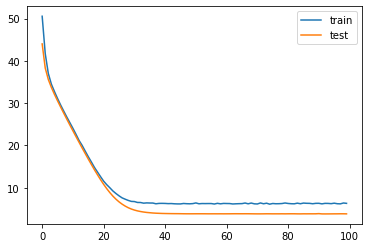

In [1591]:
df_forecast_error = pd.DataFrame(
        columns=['h', 'mae', 'rmse', 'mape', 'descriptions'])
history = model.fit([train_X,train_emb], train_y, epochs=100, batch_size=40, validation_data=([test_X,test_emb], test_y), verbose=1, shuffle=False)
# history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# # plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [1604]:
pred_y = model.predict([test_X,test_emb])
# pred_y = ts_model.predict(test_X)
pred_y.shape

(1554, 1)

In [1605]:
# pred_y=pred_y[:,0,0,0]
inverted_pred_y = y_scaler.inverse_transform(pred_y.reshape(test_y.shape))
inverted_test_y = y_scaler.inverse_transform(test_y)
original_test_price=df_original_price.to_numpy()[train_size:]
inverted_pred_y=inverted_pred_y+original_test_price
inverted_test_y=inverted_test_y+original_test_price
forecast_error=evaluate_series(inverted_test_y, inverted_pred_y, h)

print(f"GRU_{feature_name},{forecast_error['mae'][0]},{forecast_error['rmse'][0]},{forecast_error['mape'][0]}")
forecast_error

GRU_all_20,0.25729577879565246,0.4798211570081325,0.0043619089617312635


{'h': 1,
 'mae': [0.25729577879565246],
 'rmse': [0.4798211570081325],
 'mape': [0.0043619089617312635],
 'r2': [0.9995455821869985],
 'descriptions': ''}

In [1560]:
print(forecast_error)
df_forecast_error = df_forecast_error.append(
    pd.DataFrame(forecast_error), ignore_index=True)
mae = df_forecast_error["mae"]
rmse = df_forecast_error["rmse"]
mape = df_forecast_error["mape"]
k = 1
msg = f"""
Forecast Error ({k}-fold cross-validation)
X: {X.shape}
y: {y.shape}
h= {h}
Model: {model.__class__.__name__}
MAE = {mae.mean():.6f} +/- {mae.std():.3f}
RMSE = {rmse.mean():.6f} +/- {rmse.std():.3f}
MAPE = {mape.mean():.6f} +/- {mape.std():.3f}
"""
print(msg)
logging.info(msg)
evaluation_result = {
'h': h,
'mae': [mae.mean()],
'rmse': [rmse.mean()],
'mape': [mape.mean()],
'descriptions': [msg]
}
print()

{'h': 1, 'mae': [0.8115788567857242], 'rmse': [1.0420204326597036], 'mape': [0.014648791923708104], 'r2': [0.985414296864114], 'descriptions': ''}

Forecast Error (1-fold cross-validation)
X: (1942, 20)
y: (1942, 1)
h= 1
Model: Functional
MAE = 0.811579 +/- nan
RMSE = 1.042020 +/- nan
MAPE = 0.014649 +/- nan




In [1572]:
# df_forecast_error
# model.save_weights("weights.h5")
model.sa

In [ ]:
# evaluate_series(inverted_test_y, inverted_pred_y, h)

### Export Model

In [1607]:
# import pickle
# import gzip

# with gzip.GzipFile('./trained_models/model.pgz', 'w') as f:
#     pickle.dump(model, f)

In [1608]:
# with gzip.open('./trained_models/model.pgz', 'r') as f:
#     trained_model = pickle.load(f)

In [1611]:
# pred_y = trained_model.predict([test_X,test_emb])
# inverted_pred_y = y_scaler.inverse_transform(pred_y.reshape(-1, 1))
# inverted_test_y = y_scaler.inverse_transform(test_y)  # should be same as testXy
# # inverted_pred_y=inverted_pred_y.ravel()+df_original_price.Price.to_numpy()[train_size:]
# # inverted_test_y=inverted_test_y.ravel()+df_original_price.Price.to_numpy()[train_size:]
# forecast_error = evaluate_series(inverted_test_y, inverted_pred_y, h)
# forecast_error

{'h': 1,
 'mae': [0.25729577879565246],
 'rmse': [0.4798211570081325],
 'mape': [13233433202325.06],
 'r2': [0.8308924140488874],
 'descriptions': ''}

In [ ]:
# export architecture as json 
# model.to_json()

### k-fold

In [ ]:
# prepare models
step_size=1
ts_size=X.shape[-1]

ts_inputs = Input(shape=(step_size,ts_size),name='ts_input')
# ts_model = Bidirectional(GRU(300,dropout=0.3,return_sequences=False))(ts_inputs)
# ts_model = LSTM(300,dropout=0.3,return_sequences=False)(ts_inputs)
# ts_model = Bidirectional(GRU(300,dropout=0.4,return_sequences=False))(ts_model)
# ts_model= Dropout(0.4)(ts_model)
ts_model=Reshape((step_size,ts_size))(ts_inputs)
ts_model=GRU(300,dropout=0.33,return_sequences=True)(ts_model)
ts_model= Dropout(0.3)(ts_model)
ts_model=GRU(300,dropout=0.33,return_sequences=False)(ts_model)
ts_model= Dropout(0.3)(ts_model)
# ts_model=Bidirectional(ConvLSTM2D(300,(1,5),dropout=0.3,return_sequences=False))(ts_model)
# ts_model=ConvLSTM2D(300,(1,5),dropout=0.3,return_sequences=True)(ts_model)
# ts_model=ConvLSTM2D(300,(1,5),dropout=0.3,return_sequences=False)(ts_model)
# ts_model=Reshape((10,100))(ts_model)
# ts_model = Bidirectional(GRU(200,dropout=0.1,return_sequences=True))(ts_model)
# ts_model = Bidirectional(GRU(100,dropout=0.1,return_sequences=False))(ts_model)
# ts_model = Dense(1)(ts_model)
# ts_model=Reshape((1,-1))(ts_model)
# ts_model = Dense(1)(ts_model)
ts_model = Model(inputs=ts_inputs, outputs=ts_model)
# model.compile(loss='mape', optimizer='adam')
# model.summary()

In [ ]:
emb_size=emb.shape[-1]
emb_inputs = Input(shape=(10,3,emb_size),name='emb_input')
emb_model = Reshape((1,10,3,3,300),name='emb_reshape')(emb_inputs)
emb_model = Conv3D(50,(3,2,1), activation="relu",padding='valid')(emb_model)
emb_model = Dropout(0.3)(emb_model)
emb_model = Conv3D(50,(5,1,2), activation="relu",padding='valid')(emb_model)
emb_model = Dropout(0.3)(emb_model)
emb_model = Reshape((4,4,-1))(emb_model)
emb_model = Conv2D(10,(2,2), activation="relu",padding='valid')(emb_model)
emb_model = Dropout(0.3)(emb_model)
# emb_model = Reshape((1,18,-1))(emb_model)
# emb_model = Dropout(0.4)(emb_model) 
# emb_model = Dropout(0.4)(emb_model) 
emb_model = Flatten()(emb_model)
# emb_model = Dense(1)(emb_model)
# opt=Adam(0.0007)
emb_model = Model(inputs=emb_inputs, outputs=emb_model)
# emb_model.compile(loss='mae', optimizer=opt)
# emb_model = Dense(10)(emb_model)
# emb_model.compile(loss='mape', optimizer='adam')
# emb_model.summary()

In [1594]:
combined_model = concatenate([ts_model.output,emb_model.output])
combined_model= Reshape((1,-1),name='alpha')(combined_model)
combined_model= Bidirectional(GRU(100,dropout=0.33,return_sequences=False))(combined_model)
# combined_model= Bidirectional(GRU(200,dropout=0.33,return_sequences=True))(combined_model)
# combined_model= Bidirectional(SimpleRNN(100,dropout=0.3))(combined_model)
combined_model = Dropout(0.3)(combined_model)
combined_model = Dense(1)(combined_model)
model = Model(inputs=[ts_model.input,emb_model.input], outputs=combined_model)
# model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 20, 3, 900)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape_7 (Reshape)            (None, 1, 20, 3, 3,  0           ['input_6[0][0]']                
                                 300)                                                             
                                                                                                  
 conv3d_4 (Conv3D)              (None, 1, 18, 2, 3,  90050       ['reshape_7[0][0]']              
                                 50)                                                       

In [ ]:
emb.shape

train_X: (182, 1, 20) test_X:(176, 1, 20)
train_y: (182, 1) test_y:(176, 1)


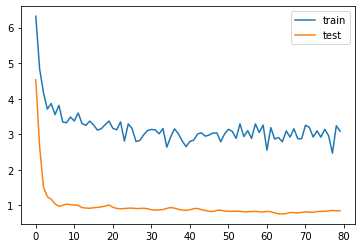

pred_y: (176, 1)
{'h': 1, 'mae': [0.19685484268183873], 'rmse': [0.4565731672784555], 'mape': [0.0021497435045786523], 'r2': [0.9967096389798883], 'descriptions': ''}
train_X: (358, 1, 20) test_X:(176, 1, 20)
train_y: (358, 1) test_y:(176, 1)


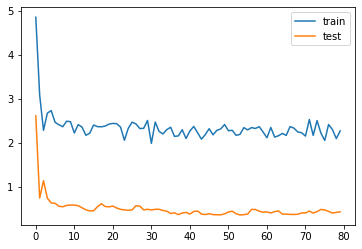

pred_y: (176, 1)
{'h': 1, 'mae': [0.14268327202748463], 'rmse': [0.18489075342558353], 'mape': [0.0015268855457023138], 'r2': [0.9986597173425984], 'descriptions': ''}
train_X: (534, 1, 20) test_X:(176, 1, 20)
train_y: (534, 1) test_y:(176, 1)


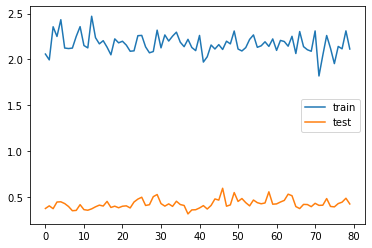

pred_y: (176, 1)
{'h': 1, 'mae': [0.14234992526238796], 'rmse': [0.18602672407254853], 'mape': [0.0014258452669801004], 'r2': [0.998405778381686], 'descriptions': ''}
train_X: (710, 1, 20) test_X:(176, 1, 20)
train_y: (710, 1) test_y:(176, 1)


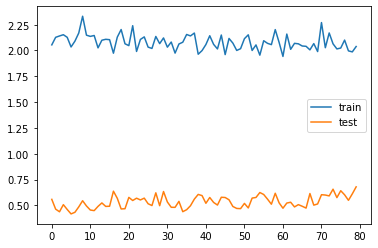

pred_y: (176, 1)
{'h': 1, 'mae': [0.19822618593906327], 'rmse': [0.2542080744868304], 'mape': [0.0023580601238502295], 'r2': [0.9997133241664966], 'descriptions': ''}
train_X: (886, 1, 20) test_X:(176, 1, 20)
train_y: (886, 1) test_y:(176, 1)


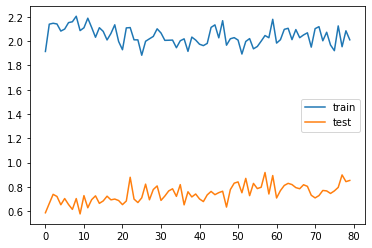

pred_y: (176, 1)
{'h': 1, 'mae': [0.22961464877960036], 'rmse': [0.30161728983930036], 'mape': [0.004613750219735519], 'r2': [0.9975096415467993], 'descriptions': ''}
train_X: (1062, 1, 20) test_X:(176, 1, 20)
train_y: (1062, 1) test_y:(176, 1)


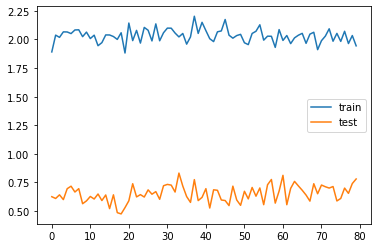

pred_y: (176, 1)
{'h': 1, 'mae': [0.21802344372141488], 'rmse': [0.2737742493410335], 'mape': [0.005575892669299084], 'r2': [0.9980931932124815], 'descriptions': ''}
train_X: (1238, 1, 20) test_X:(176, 1, 20)
train_y: (1238, 1) test_y:(176, 1)


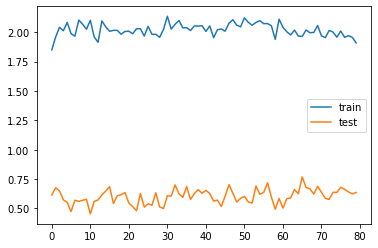

pred_y: (176, 1)
{'h': 1, 'mae': [0.18992214919364292], 'rmse': [0.24693190058361014], 'mape': [0.003955833857782324], 'r2': [0.9958740998955141], 'descriptions': ''}
train_X: (1414, 1, 20) test_X:(176, 1, 20)
train_y: (1414, 1) test_y:(176, 1)


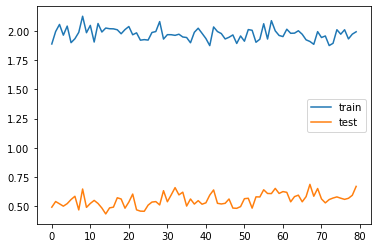

pred_y: (176, 1)
{'h': 1, 'mae': [0.19331065398566818], 'rmse': [0.24783913595893176], 'mape': [0.003954625439630091], 'r2': [0.9932112070878976], 'descriptions': ''}
train_X: (1590, 1, 20) test_X:(176, 1, 20)
train_y: (1590, 1) test_y:(176, 1)


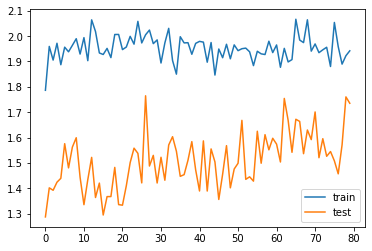

pred_y: (176, 1)
{'h': 1, 'mae': [0.38909347987600107], 'rmse': [0.5129998976788966], 'mape': [0.006005776413510202], 'r2': [0.9878298140171375], 'descriptions': ''}
train_X: (1766, 1, 20) test_X:(176, 1, 20)
train_y: (1766, 1) test_y:(176, 1)


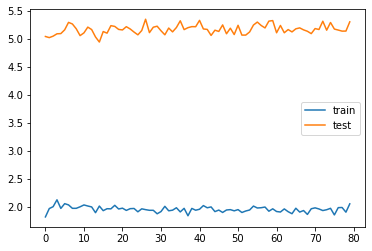

pred_y: (176, 1)
{'h': 1, 'mae': [1.0048507724417668], 'rmse': [1.3119762590598483], 'mape': [0.017346911270679832], 'r2': [0.9762727525033206], 'descriptions': ''}

    Forecast Error (10-fold cross-validation)
    X: (1942, 20)
    y: (1942, 1)
    h= 1
    Model: Functional
    MAE = 0.290493 +/- 0.260
    RMSE = 0.397684 +/- 0.339
    MAPE = 0.004891 +/- 0.005
    


In [1596]:
try:
    cv = get_TS_cv()
    df_forecast_error = pd.DataFrame(
        columns=['h', 'mae', 'rmse', 'mape', 'descriptions'])
    for train_idx, test_idx in cv.split(y):
        # split train/test set for emb,X,y      
        train_X = X[train_idx,:]
        test_X = X[test_idx,:]
        train_emb=emb[train_idx,:,:]
        test_emb=emb[test_idx,:,:]
        train_y = y[train_idx]
        test_y = y[test_idx]

        # normalize features
        X_scaler = MinMaxScaler()
        X_scaler.fit(train_X)
        y_scaler = MinMaxScaler(feature_range=(1, 100))
        y_scaler.fit(train_y)

        train_X=X_scaler.transform(train_X)
        test_X=X_scaler.transform(test_X)
        train_y=y_scaler.transform(train_y)
        test_y=y_scaler.transform(test_y)

        # reshape to 3D for RNN/LSTM/GRU       
        train_X=train_X.reshape(train_X.shape[0],step_size,train_X.shape[-1])
        test_X=test_X.reshape(test_X.shape[0],step_size,test_X.shape[-1])
        print(f"train_X: {train_X.shape} test_X:{test_X.shape}")
        print(f"train_y: {train_y.shape} test_y:{test_y.shape}")

        # model = Model(inputs=ts_inputs, outputs=ts_model)
        # model = Model(inputs=emb_inputs, outputs=emb_model)
        model = Model(inputs=[ts_model.input,emb_model.input], outputs=combined_model)
        # model.compile(loss='mae', optimizer=opt)
        # model.compile(loss='msle', optimizer=Adam(0.0005))
        model.compile(loss='log_cosh', optimizer=Adam(0.0002))
        # history = model.fit(x=train_X, y=train_y, epochs=80, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)
        # history = model.fit(x=train_emb, y=train_y, epochs=80, batch_size=100, validation_data=(test_emb, test_y), verbose=0, shuffle=False)
        history = model.fit(x=[train_X,train_emb], y=train_y, epochs=80, batch_size=40, validation_data=([test_X,test_emb], test_y), verbose=0, shuffle=False)
        
        # plot history
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='test')
        pyplot.legend()
        pyplot.show()

        # pred_y = model.predict(test_X)
        # pred_y = model.predict(test_emb)
        pred_y = model.predict([test_X,test_emb])
        print(f"pred_y: {pred_y.shape}")

        # scale
        inverted_pred_y = y_scaler.inverse_transform(pred_y.reshape(test_y.shape))
        inverted_test_y = y_scaler.inverse_transform(test_y)
        original_test_price=df_original_price.to_numpy()[test_idx]
        inverted_pred_y=inverted_pred_y+original_test_price
        inverted_test_y=inverted_test_y+original_test_price

        forecast_error = evaluate_series(inverted_test_y, inverted_pred_y, h)
        # forecast_error = evaluate_series(test_y.reshape(-1, 1), pred_y.reshape(-1, 1), h)
        print(forecast_error)
        df_forecast_error = df_forecast_error.append(
            pd.DataFrame(forecast_error), ignore_index=True)
    mae = df_forecast_error["mae"]
    rmse = df_forecast_error["rmse"]
    mape = df_forecast_error["mape"]
    k = cv.get_n_splits()
    msg = f"""
    Forecast Error ({k}-fold cross-validation)
    X: {X.shape}
    y: {y.shape}
    h= {h}
    Model: {model.__class__.__name__}
    MAE = {mae.mean():.6f} +/- {mae.std():.3f}
    RMSE = {rmse.mean():.6f} +/- {rmse.std():.3f}
    MAPE = {mape.mean():.6f} +/- {mape.std():.3f}
    """
    print(msg)
    logging.info(msg)
    evaluation_result = {
        'h': h,
        'mae': [mae.mean()],
        'rmse': [rmse.mean()],
        'mape': [mape.mean()],
        'descriptions': [msg]
    }    
except Exception as e:
    logging.exception("EXCEPTION: %s", e, exc_info=True)
tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)

#### k-fold results

In [ ]:
print(f"multi,{df_forecast_error['mae'].to_numpy().mean()},{df_forecast_error['rmse'].to_numpy().mean()},{df_forecast_error['mape'].to_numpy().mean()}")
df_forecast_error

In [ ]:
# model_log="BiGRU;"
# FE_log="CLC1(h=1); 1stDIFF(xy)+ RFE(Ridge,60); scale y;"
# msg=f"{model_log} {FE_log} mse;"
# evaluation_result["descriptions"]=msg
# df_result = pd.DataFrame(evaluation_result)
# df_result["time"] = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")

# df_result = df_result[['time', 'descriptions', 'h', 'mae', 'rmse', 'mape']]
# df_result

In [ ]:
# df_result.to_csv(f"{HOME}/results/experiment_results.csv",mode="a+",index=False,header=False)